In [343]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import edward2 as ed
tfd = tfp.distributions

import seaborn as sns
import pandas as pd
%matplotlib inline

tf.reset_default_graph()

# np.random.seed(111)
# tf.set_random_seed(111)


In [344]:
def grav_analytical(x, sphere_center, sphere_radius, density_difference):
    """Calculate gravitational effect of a sphere, measured at surface
    
    **Arguments**:
    - 'x' = scalar or np.array: position(s) of observation
    - 'sphere_center' = float: is the vertical position of the center of the sphere (lateral position at origin)
    - 'sphere_radius' = float: sphere radius
    - 'density_difference' = float: density difference to the surrounding domain
    """
    G=6.67e-11 # gravitational constant
    return ((4/3)*np.pi * (sphere_radius**3) * density_difference
            * G * sphere_center/(x**2 + sphere_center**2)**(3/2)) * 1e5


In [345]:
sphere_center = 300. #m 
sphere_radius = 100. #m
density_difference = 500. # kg/m^3: density diffrence to surrounding domain
x_domain=np.linspace(-1000,1000,101) #m

In [346]:
# x_obs = 0
x_obs = np.linspace(-250, 250, 11)
grav_all = grav_analytical(x_domain, sphere_center, sphere_radius, density_difference)
grav_obs_array = grav_analytical(x_obs, sphere_center, sphere_radius, density_difference)
noise = norm(0,0.01).rvs(len(grav_obs_array))
grav_obs_array_noise = grav_obs_array +noise
grav_obs_array_noise_sum = np.sum(grav_obs_array_noise)

In [347]:
noise_variance = np.var(noise)

In [348]:
noise_variance

7.397617321887826e-05

In [349]:
noise_1 = tf.convert_to_tensor([noise_variance],dtype = tf.float32)

In [350]:
noise_1

<tf.Tensor 'Const:0' shape=(1,) dtype=float32>

In [351]:
noise_tensor = tf.diag(noise_1)

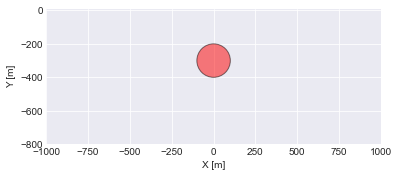

In [352]:
plt.style.use('seaborn-darkgrid')
ax = plt.subplot(aspect='equal') 

# create circle object as matplotlib patch
circle1 = plt.Circle((0, -sphere_center), sphere_radius, 
                     facecolor='r', edgecolor='k', alpha=0.5)

ax.add_artist(circle1)

# set model domain
ax.set_xlim([-1000,1000])
ax.set_ylim([-800,10])

ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
plt.savefig('./Simple_grav_img/SG_noise_3_para/model.png')

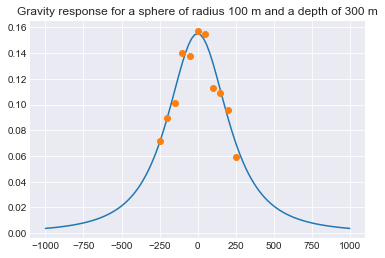

In [353]:
plt.plot(x_domain, grav_all)
plt.plot(x_obs, grav_obs_array_noise, 'o', label="data")
plt.title("Gravity response for a sphere of radius 100 m and a depth of 300 m");
plt.savefig('./Simple_grav_img/SG_noise_3_para/gravity.png')

### NEW

Bayes’s Theorem

\begin{equation}
d \mu_{\mathrm{post}}\left(m | \mathbf{d}_{\mathrm{obs}}\right) \propto \pi_{\mathrm{like}}\left(\mathbf{d}_{\mathrm{obs}} | \mathrm{m}\right) \mathrm{d} \mu_{\mathrm{prior}}(\mathrm{m})
\end{equation}

Prior
\begin{equation}
\mu_{\text {prior }} \sim \mathcal{N}\left(m_{\text {prior }}, C_{\text {prior }}\right)
\end{equation}

In [354]:
mu_prior = [250., 450., 100.]
mu_prior = tf.convert_to_tensor(mu_prior)

The likelihood
\begin{equation}
\mathbf{d}_{\mathrm{obs}}=\mathbf{f}(\mathrm{m})+\mathbf{e}, \quad \mathbf{e} \sim \mathcal{N}\left(\mathbf{0}, \mathbf{\Gamma}_{\mathrm{noise}}\right)
\end{equation}
\begin{equation}
\pi_{\text {like }}\left(\mathbf{d}_{\text {obs }} | \mathrm{m}\right)=\exp \left(-\frac{1}{2}\left\|\mathbf{f}(\mathrm{m})-\mathbf{d}_{\text {obs }}\right\|_{\Gamma_{\text {noise }}^{-1}}^{2}\right)
\end{equation}

In [355]:
## initial guess

mu = tf.get_variable("mu", dtype=tf.float32,
  initializer=tf.constant([280., 470., 120.]))
# true = [300., 500., 100.]


In [356]:
x_obs

array([-250., -200., -150., -100.,  -50.,    0.,   50.,  100.,  150.,
        200.,  250.])

In [357]:
# Defind f(m). Here f is the parameter-to-observable map that takes a 
# parameter m and maps it to the space observation vector dobs.

def grav_analytical_tf(x, mu, cov):
    # [sphere_center, density_difference, sphere_radius]

    mvn = ed.MultivariateNormalFullCovariance(
            loc = mu,
            covariance_matrix= cov)
    G=6.67e-11
    sphere_center = mvn.__getitem__(0)
    density_difference = mvn.__getitem__(1)
    sphere_radius = mvn.__getitem__(2)
    
    gravity = tf.reduce_sum(((4/3)*np.pi * (sphere_radius**3) * density_difference* G * sphere_center/(x**2 + sphere_center**2)**(3/2)) * 1e5 ,keepdims=True)

    
    return gravity



# with tf.Session() as session:
#     session.run(init)
#     grav = grav_analytical_tf(x_obs,mu, cov)
#     print(grav)
    



### Gradient decent to find MAP (?)

In [358]:
import tensorflow.math as tm

## function compute G^T C^-1 G

def matrixcompute(matrix1,matrix2,Cov):
    matrix = tf.subtract(matrix1, matrix2)
    matrix = tf.reshape(matrix,[matrix.shape[0],1])
    matrix_T = tf.transpose(matrix)
    Cov_inv = tf.linalg.inv(Cov)
    result = tf.multiply(tf.constant(1/2),tf.matmul(tf.matmul(matrix_T,Cov_inv),matrix))
    
    return result

In [359]:
matrix = tf.subtract(mu,mu_prior)


\begin{equation}
\pi_{\text {like }}\left(\mathbf{d}_{\text {obs }} | \mathrm{m}\right)=\exp \left(-\frac{1}{2}\left\|\mathbf{f}(\mathrm{m})-\mathbf{d}_{\text {obs }}\right\|_{\Gamma_{\text {noise }}^{-1}}^{2}\right)
\end{equation}

#### The posterior


\begin{equation}
d \mu_{\mathrm{post}}\left(m | \mathbf{d}_{\mathrm{obs}}\right) \propto \exp \left(-\frac{1}{2}\left\|\mathbf{f}(\mathrm{m})-\mathbf{d}_{\mathrm{obs}}\right\|_{\mathrm{\Gamma}_{\mathrm{noise}}^{-1}}^{2}-\frac{1}{2}\left\|\mathrm{m}-\mathrm{m}_{\mathrm{prior}}\right\|_{C_{\mathrm{prior}}^{-1}}^{2}\right)
\end{equation}

#### negative log of the posterior
\begin{equation}
\left(\frac{1}{2}\left\|\mathbf{f}(\mathrm{m})-\mathbf{d}_{\mathrm{obs}}\right\|_{\mathrm{\Gamma}_{\mathrm{noise}}^{-1}}^{2}+\frac{1}{2}\left\|\mathrm{m}-\mathrm{m}_{\mathrm{prior}}\right\|_{C_{\mathrm{prior}}^{-1}}^{2}\right)
\end{equation}


term 1
\begin{equation}
\frac{1}{2}\left\|\mathbf{f}(\mathrm{m})-\mathbf{d}_{\text {obs }}\right\|_{\Gamma_{\text {noise }}^{-1}}^{2}
\end{equation}

In [360]:
grav_obs_array_noise_sum = tf.convert_to_tensor(grav_obs_array_noise_sum,dtype=tf.float32)

In [361]:
cov = [[ 20.,  0.,  0.],
        [ 0.,  20., 0.],
        [ 0., 0.,  20.]]
cov = tf.convert_to_tensor(cov)

\begin{equation}
\frac{1}{2}\left\|\mathrm{m}-\mathrm{m}_{\mathrm{prior}}\right\|_{C_{\mathrm{prior}}^{-1}}^{2}
\end{equation}


In [364]:
init = tf.global_variables_initializer()
with tf.Session() as session:
    session.run(init)
    grav = grav_analytical_tf(x_obs,mu, cov)
    term_1 = matrixcompute(grav,grav_obs_array_noise_sum,noise_tensor)
    term_2 = matrixcompute(mu,mu_prior,cov)
    Negtive_log_likelihood = tf.add(term_1,term_2)
    
    optimizer = tf.train.GradientDescentOptimizer(0.01)
    train = optimizer.minimize(Negtive_log_likelihood)
    
    print("starting at", "mu:", session.run(mu), "negative log likelihood:", session.run(Negtive_log_likelihood))
    for step in range(10000):  
        session.run(train)
#         print("step", step, "noise_tensor:", session.run(noise_tensor))
#         print("step", step, "cov:", session.run(cov))
        print("step", step, "mu:", session.run(mu), "negative log likelihood:", session.run(Negtive_log_likelihood))


    

starting at mu: [280. 470. 120.] negative log likelihood: [[14047.623]]
step 0 mu: [282.5846   468.97537  108.448326] negative log likelihood: [[1884.9354]]
step 1 mu: [283.9039  468.43637 102.11502] negative log likelihood: [[1040.6456]]
step 2 mu: [284.26544  468.27277  100.141045] negative log likelihood: [[227.45514]]
step 3 mu: [284.1921  468.2857  100.46977] negative log likelihood: [[37.592205]]
step 4 mu: [284.3301  468.2146   99.62026] negative log likelihood: [[98.84927]]
step 5 mu: [284.40982  468.1656    99.083115] negative log likelihood: [[188.6747]]
step 6 mu: [285.23297 467.82205  94.89613] negative log likelihood: [[484.70496]]
step 7 mu: [285.02475  467.89032   96.088295] negative log likelihood: [[445.63596]]
step 8 mu: [285.07065 467.85593  95.734  ] negative log likelihood: [[525.57294]]
step 9 mu: [284.9667  467.88248  96.24523] negative log likelihood: [[92.17842]]
step 10 mu: [284.83328 467.92038  96.93855] negative log likelihood: [[48.064808]]
step 11 mu: [284

step 147 mu: [283.48773 466.38     96.61841] negative log likelihood: [[239.16785]]
step 148 mu: [283.592    466.32318   95.948875] negative log likelihood: [[35.6929]]
step 149 mu: [283.4852  466.35162  96.47993] negative log likelihood: [[591.17725]]
step 150 mu: [283.4619  466.3461   96.51918] negative log likelihood: [[137.85135]]
step 151 mu: [283.26416 466.4103   97.62643] negative log likelihood: [[42.08988]]
step 152 mu: [283.1477  466.4422   98.21381] negative log likelihood: [[34.31279]]
step 153 mu: [283.30237 466.36533  97.2826 ] negative log likelihood: [[34.652225]]
step 154 mu: [283.2082  466.3874   97.73996] negative log likelihood: [[84.865875]]
step 155 mu: [283.3689  466.3074   96.77191] negative log likelihood: [[570.21326]]
step 156 mu: [283.24384 466.3429   97.41785] negative log likelihood: [[35.03628]]
step 157 mu: [283.26306 466.3206   97.2169 ] negative log likelihood: [[133.16228]]
step 158 mu: [283.11942 466.3633   97.98117] negative log likelihood: [[299.15

step 287 mu: [281.99606 464.98093  97.67358] negative log likelihood: [[54.74309]]
step 288 mu: [281.91953 464.99765  98.02727] negative log likelihood: [[32.693077]]
step 289 mu: [282.02533 464.94077  97.35681] negative log likelihood: [[1613.8116]]
step 290 mu: [281.98032 464.94522  97.52498] negative log likelihood: [[289.1715]]
step 291 mu: [281.82935 464.9912   98.33792] negative log likelihood: [[35.786068]]
step 292 mu: [281.75897 465.00537  98.65811] negative log likelihood: [[177.36172]]
step 293 mu: [281.79272  464.9783    98.378555] negative log likelihood: [[273.50006]]
step 294 mu: [281.6941  465.00403  98.8613 ] negative log likelihood: [[591.33514]]
step 295 mu: [281.57986  465.03653   99.438736] negative log likelihood: [[53.66037]]
step 296 mu: [281.47852 465.06317  99.93714] negative log likelihood: [[1316.8624]]
step 297 mu: [281.72467 464.95157  98.52914] negative log likelihood: [[709.8562]]
step 298 mu: [281.64404 464.96985  98.9072 ] negative log likelihood: [[51

step 431 mu: [280.44724 463.70236  99.70071] negative log likelihood: [[27.930775]]
step 432 mu: [280.3049  463.746   100.46222] negative log likelihood: [[490.2236]]
step 433 mu: [280.21487 463.7695  100.89568] negative log likelihood: [[212.87518]]
step 434 mu: [280.06223 463.81857 101.71451] negative log likelihood: [[68.38162]]
step 435 mu: [279.88333 463.87738 102.71128] negative log likelihood: [[27.359781]]
step 436 mu: [280.213    463.73196  100.903275] negative log likelihood: [[56.146236]]
step 437 mu: [280.23706 463.70868 100.68431] negative log likelihood: [[278.92056]]
step 438 mu: [280.55173  463.57254   98.933395] negative log likelihood: [[47.94873]]
step 439 mu: [281.02115 463.37466  96.44037] negative log likelihood: [[294.41718]]
step 440 mu: [281.58896  463.1329    93.477715] negative log likelihood: [[765.9998]]
step 441 mu: [281.4428  463.17957  94.25949] negative log likelihood: [[63.934933]]
step 442 mu: [281.24225 463.24774  95.4017 ] negative log likelihood: [

step 577 mu: [280.0769  462.06876  97.51063] negative log likelihood: [[115.9359]]
step 578 mu: [279.95865 462.10425  98.11826] negative log likelihood: [[1187.3424]]
step 579 mu: [280.02927  462.0642    97.646065] negative log likelihood: [[140.98172]]
step 580 mu: [279.83707 462.12897  98.73849] negative log likelihood: [[36.067024]]
step 581 mu: [279.92166  462.0841    98.190735] negative log likelihood: [[881.0459]]
step 582 mu: [280.00906 462.0368   97.62911] negative log likelihood: [[112.52814]]
step 583 mu: [280.23907  461.9325    96.325226] negative log likelihood: [[136.69514]]
step 584 mu: [280.2006  461.93597  96.46013] negative log likelihood: [[342.4404]]
step 585 mu: [280.206    461.92172   96.346535] negative log likelihood: [[81.9033]]
step 586 mu: [280.10092 461.95197  96.87315] negative log likelihood: [[59.696198]]
step 587 mu: [279.9835  461.98685  97.47513] negative log likelihood: [[32.392265]]
step 588 mu: [280.13382  461.91348   96.578384] negative log likeliho

step 722 mu: [279.30063 460.7151   96.10875] negative log likelihood: [[25.423706]]
step 723 mu: [279.3234  460.69498  95.90189] negative log likelihood: [[600.15454]]
step 724 mu: [279.17172  460.7438    96.720375] negative log likelihood: [[279.20605]]
step 725 mu: [279.46783 460.61664  95.08796] negative log likelihood: [[134.72028]]
step 726 mu: [279.3319  460.65973  95.80477] negative log likelihood: [[206.68065]]
step 727 mu: [279.0702  460.75574  97.40594] negative log likelihood: [[69.448364]]
step 728 mu: [279.394    460.612     95.631645] negative log likelihood: [[161.85852]]
step 729 mu: [279.62292 460.50638  94.33768] negative log likelihood: [[481.16006]]
step 730 mu: [279.4113  460.58173  95.54374] negative log likelihood: [[226.1712]]
step 731 mu: [279.4004  460.57486  95.52465] negative log likelihood: [[174.56549]]
step 732 mu: [279.3673   460.57693   95.631226] negative log likelihood: [[25.048502]]
step 733 mu: [279.17184  460.64453   96.743416] negative log likelih

step 865 mu: [277.94592 459.7344   99.34852] negative log likelihood: [[39.898666]]
step 866 mu: [277.8068  459.77982 100.09143] negative log likelihood: [[68.593475]]
step 867 mu: [278.0043  459.6897   98.95731] negative log likelihood: [[1460.4867]]
step 868 mu: [278.67908  459.40652   95.505165] negative log likelihood: [[467.81396]]
step 869 mu: [278.49213 459.47205  96.55544] negative log likelihood: [[27.63631]]
step 870 mu: [278.44427 459.4807   96.74935] negative log likelihood: [[26.56534]]
step 871 mu: [278.3208  459.51926  97.39096] negative log likelihood: [[48.830273]]
step 872 mu: [278.28958 459.52145  97.48887] negative log likelihood: [[227.10944]]
step 873 mu: [278.21948  459.539     97.815475] negative log likelihood: [[56.7601]]
step 874 mu: [278.04645 459.59882  98.76905] negative log likelihood: [[152.42947]]
step 875 mu: [278.2075   459.5246    97.823395] negative log likelihood: [[160.15216]]
step 876 mu: [278.032   459.58484  98.80258] negative log likelihood: [

step 1006 mu: [277.3038  458.58456  98.48198] negative log likelihood: [[202.42169]]
step 1007 mu: [277.30252  458.57532   98.413315] negative log likelihood: [[50.30143]]
step 1008 mu: [277.30142  458.5661    98.343765] negative log likelihood: [[609.33685]]
step 1009 mu: [277.1385  458.62134  99.23962] negative log likelihood: [[110.472855]]
step 1010 mu: [277.03452 458.6532   99.76617] negative log likelihood: [[2298.8076]]
step 1011 mu: [277.08243 458.62363  99.42809] negative log likelihood: [[24.061691]]
step 1012 mu: [277.3832  458.49448  97.77121] negative log likelihood: [[318.89206]]
step 1013 mu: [277.4914  458.4403   97.10895] negative log likelihood: [[773.77466]]
step 1014 mu: [277.33435 458.49362  97.96535] negative log likelihood: [[666.5107]]
step 1015 mu: [277.19238  458.5404    98.722755] negative log likelihood: [[22.134645]]
step 1016 mu: [277.28473 458.4935   98.14523] negative log likelihood: [[890.28204]]
step 1017 mu: [277.32886 458.46597  97.82517] negative lo

step 1150 mu: [276.93283  457.38077   96.071556] negative log likelihood: [[156.30469]]
step 1151 mu: [277.00592 457.343    95.59954] negative log likelihood: [[29.586649]]
step 1152 mu: [276.83252 457.4022   96.55878] negative log likelihood: [[21.834814]]
step 1153 mu: [276.69177 457.4512   97.30547] negative log likelihood: [[226.7025]]
step 1154 mu: [276.60706 457.47617  97.71817] negative log likelihood: [[297.31384]]
step 1155 mu: [276.57602 457.4796   97.82019] negative log likelihood: [[285.69687]]
step 1156 mu: [276.40643 457.53912  98.75764] negative log likelihood: [[69.04834]]
step 1157 mu: [276.49884 457.4938   98.17984] negative log likelihood: [[396.94803]]
step 1158 mu: [276.48898 457.4887   98.16161] negative log likelihood: [[19.266262]]
step 1159 mu: [276.70618 457.39282  96.93762] negative log likelihood: [[30.454445]]
step 1160 mu: [276.65186  457.40558   97.173676] negative log likelihood: [[489.04816]]
step 1161 mu: [276.53262 457.4443   97.79369] negative log li

step 1294 mu: [275.96756 456.52917  97.68261] negative log likelihood: [[209.88087]]
step 1295 mu: [276.01376 456.5013   97.35793] negative log likelihood: [[231.27283]]
step 1296 mu: [275.97708  456.50784   97.493744] negative log likelihood: [[18.134468]]
step 1297 mu: [276.28708 456.37314  95.80723] negative log likelihood: [[209.1533]]
step 1298 mu: [276.1381  456.42413  96.61657] negative log likelihood: [[21.241226]]
step 1299 mu: [275.98175 456.47855  97.47067] negative log likelihood: [[73.32509]]
step 1300 mu: [275.89496  456.5047    97.897194] negative log likelihood: [[60.866158]]
step 1301 mu: [276.07233 456.42514  96.87703] negative log likelihood: [[20.491024]]
step 1302 mu: [275.90292  456.48416   97.814545] negative log likelihood: [[569.0263]]
step 1303 mu: [276.0749  456.406    96.82117] negative log likelihood: [[238.53242]]
step 1304 mu: [275.9599  456.44446  97.41851] negative log likelihood: [[69.68346]]
step 1305 mu: [275.97415 456.43027  97.26704] negative log l

step 1430 mu: [275.25293 455.7322   98.47192] negative log likelihood: [[181.90134]]
step 1431 mu: [275.18286  455.75266   98.801575] negative log likelihood: [[86.42811]]
step 1432 mu: [275.26596 455.7106   98.27535] negative log likelihood: [[169.23846]]
step 1433 mu: [275.32306 455.67987  97.89302] negative log likelihood: [[480.58862]]
step 1434 mu: [275.36902 455.6537   97.56902] negative log likelihood: [[17.19313]]
step 1435 mu: [275.25278 455.69296  98.17717] negative log likelihood: [[17.435059]]
step 1436 mu: [275.2048  455.70438  98.37891] negative log likelihood: [[285.50098]]
step 1437 mu: [275.17465 455.70862  98.47857] negative log likelihood: [[334.08618]]
step 1438 mu: [275.20016 455.69006  98.26794] negative log likelihood: [[31.015427]]
step 1439 mu: [275.34512  455.62302   97.414406] negative log likelihood: [[31.526962]]
step 1440 mu: [275.3285   455.6218    97.437675] negative log likelihood: [[65.85083]]
step 1441 mu: [275.29333 455.62793  97.56704] negative log 

step 1569 mu: [274.90662  454.82733   96.202774] negative log likelihood: [[220.98834]]
step 1570 mu: [274.7943  454.86447  96.78625] negative log likelihood: [[101.44534]]
step 1571 mu: [274.9245  454.8035   96.01718] negative log likelihood: [[351.37997]]
step 1572 mu: [274.91327 454.8006   96.01229] negative log likelihood: [[92.195496]]
step 1573 mu: [274.7693   454.85046   96.785194] negative log likelihood: [[33.73506]]
step 1574 mu: [274.61972 454.90387  97.60014] negative log likelihood: [[158.22517]]
step 1575 mu: [274.51492 454.93842  98.13436] negative log likelihood: [[212.72842]]
step 1576 mu: [274.39188 454.98105  98.78061] negative log likelihood: [[16.553047]]
step 1577 mu: [274.9338  454.754    95.98309] negative log likelihood: [[1174.592]]
step 1578 mu: [274.90753 454.75714  96.06372] negative log likelihood: [[52.420967]]
step 1579 mu: [274.842   454.7759   96.36913] negative log likelihood: [[39.71009]]
step 1580 mu: [274.78406  454.79205   96.631645] negative log 

step 1716 mu: [274.1216   454.11823   96.845085] negative log likelihood: [[1787.4972]]
step 1717 mu: [273.93283 454.18588  97.91191] negative log likelihood: [[62.225304]]
step 1718 mu: [273.97437 454.16272  97.61736] negative log likelihood: [[63.814987]]
step 1719 mu: [273.88174 454.19257  98.08194] negative log likelihood: [[439.92548]]
step 1720 mu: [273.8317  454.20572  98.29933] negative log likelihood: [[124.07541]]
step 1721 mu: [274.17508 454.06067  96.4461 ] negative log likelihood: [[17.594372]]
step 1722 mu: [274.3288  453.99347  95.55174] negative log likelihood: [[420.89117]]
step 1723 mu: [274.17523 454.04953  96.39907] negative log likelihood: [[120.89853]]
step 1724 mu: [274.20316 454.03128  96.17686] negative log likelihood: [[51.347237]]
step 1725 mu: [274.1967  454.02698  96.14739] negative log likelihood: [[373.02856]]
step 1726 mu: [273.99393  454.1042    97.315544] negative log likelihood: [[206.00018]]
step 1727 mu: [273.82495 454.1653   98.26142] negative log 

step 1860 mu: [273.32794 453.5108   97.5401 ] negative log likelihood: [[353.525]]
step 1861 mu: [273.33792 453.5004   97.42126] negative log likelihood: [[108.61489]]
step 1862 mu: [273.25433 453.52704  97.83312] negative log likelihood: [[15.886834]]
step 1863 mu: [273.5222  453.41473  96.3575 ] negative log likelihood: [[153.72594]]
step 1864 mu: [273.41736  453.45078   96.898346] negative log likelihood: [[196.29045]]
step 1865 mu: [273.38705  453.45642   97.004814] negative log likelihood: [[121.99099]]
step 1866 mu: [273.594    453.36768   95.841446] negative log likelihood: [[966.8707]]
step 1867 mu: [273.41446 453.43222  96.85677] negative log likelihood: [[38.09515]]
step 1868 mu: [273.25546 453.4898   97.73338] negative log likelihood: [[159.31897]]
step 1869 mu: [273.0276  453.57358  99.07506] negative log likelihood: [[1875.853]]
step 1870 mu: [273.04395 453.56033  98.9209 ] negative log likelihood: [[162.60686]]
step 1871 mu: [272.86234 453.62814  99.94848] negative log li

step 2005 mu: [273.50348  452.5558    93.757835] negative log likelihood: [[27.363728]]
step 2006 mu: [273.4409  452.57507  94.05027] negative log likelihood: [[218.13087]]
step 2007 mu: [273.19263 452.66675  95.54896] negative log likelihood: [[828.6393]]
step 2008 mu: [273.07867 452.70605  96.14236] negative log likelihood: [[264.6818]]
step 2009 mu: [273.1636  452.66528  95.61656] negative log likelihood: [[73.29968]]
step 2010 mu: [273.1385  452.66956  95.69459] negative log likelihood: [[30.26883]]
step 2011 mu: [272.99664 452.72064  96.46243] negative log likelihood: [[68.708046]]
step 2012 mu: [272.91882  452.74622   96.845474] negative log likelihood: [[21.34373]]
step 2013 mu: [272.82324 452.77847  97.33232] negative log likelihood: [[380.06595]]
step 2014 mu: [272.6509  452.8411   98.30271] negative log likelihood: [[13.842345]]
step 2015 mu: [272.56134 452.87088  98.75317] negative log likelihood: [[47.61223]]
step 2016 mu: [272.8671   452.74158   97.091324] negative log lik

step 2149 mu: [272.44785 452.15054  97.25529] negative log likelihood: [[860.14215]]
step 2150 mu: [273.0749  451.8937   94.04426] negative log likelihood: [[710.49414]]
step 2151 mu: [273.0497   451.89822   94.124466] negative log likelihood: [[284.4436]]
step 2152 mu: [273.06003  451.88855   94.006454] negative log likelihood: [[743.39966]]
step 2153 mu: [273.1606  451.84326  93.39813] negative log likelihood: [[103.71589]]
step 2154 mu: [273.1416  451.8453   93.44316] negative log likelihood: [[16.918562]]
step 2155 mu: [273.00284  451.8956    94.195366] negative log likelihood: [[43.064846]]
step 2156 mu: [272.93     451.9188    94.547844] negative log likelihood: [[26.365337]]
step 2157 mu: [272.9284  451.914    94.49567] negative log likelihood: [[57.40207]]
step 2158 mu: [273.02692 451.86902  93.90144] negative log likelihood: [[433.02386]]
step 2159 mu: [272.8851  451.9208   94.66891] negative log likelihood: [[13.896199]]
step 2160 mu: [272.9001  451.90912  94.52514] negative 

step 2295 mu: [272.0188  451.55414  97.63085] negative log likelihood: [[277.09143]]
step 2296 mu: [271.81635 451.63214  98.7993 ] negative log likelihood: [[649.4597]]
step 2297 mu: [271.7744  451.64352  98.97583] negative log likelihood: [[257.3221]]
step 2298 mu: [271.72626 451.65787  99.18764] negative log likelihood: [[286.8663]]
step 2299 mu: [271.87012 451.59433  98.35477] negative log likelihood: [[15.497269]]
step 2300 mu: [271.93018 451.565    97.96661] negative log likelihood: [[23.028889]]
step 2301 mu: [271.89468 451.5742   98.10508] negative log likelihood: [[58.1334]]
step 2302 mu: [271.66937 451.65955  99.43146] negative log likelihood: [[603.8707]]
step 2303 mu: [271.69785 451.64255  99.21449] negative log likelihood: [[43.155823]]
step 2304 mu: [271.7122  451.63153  99.07473] negative log likelihood: [[408.84384]]
step 2305 mu: [272.01596 451.5049   97.43573] negative log likelihood: [[71.92347]]
step 2306 mu: [271.8417  451.56836  98.41613] negative log likelihood: [

step 2440 mu: [271.39944 451.10776  98.48229] negative log likelihood: [[32.011837]]
step 2441 mu: [271.29926 451.14243  98.99467] negative log likelihood: [[85.564415]]
step 2442 mu: [271.17975 451.18613  99.62486] negative log likelihood: [[142.80988]]
step 2443 mu: [271.201    451.17242   99.448746] negative log likelihood: [[30.695305]]
step 2444 mu: [271.631   450.99274  97.20106] negative log likelihood: [[86.30132]]
step 2445 mu: [271.5967  451.0017   97.33502] negative log likelihood: [[114.32943]]
step 2446 mu: [271.655   450.9739   96.95712] negative log likelihood: [[265.9888]]
step 2447 mu: [271.92313 450.85928  95.4888 ] negative log likelihood: [[83.621376]]
step 2448 mu: [271.83847 450.8887   95.91273] negative log likelihood: [[18.756672]]
step 2449 mu: [271.7771   450.90866   96.202034] negative log likelihood: [[844.81146]]
step 2450 mu: [271.54242 450.99634  97.59135] negative log likelihood: [[20.083498]]
step 2451 mu: [271.41568 451.04272  98.27116] negative log li

step 2581 mu: [270.96793 450.62537  97.15144] negative log likelihood: [[115.27318]]
step 2582 mu: [270.81216 450.68262  98.01207] negative log likelihood: [[591.62915]]
step 2583 mu: [270.83408  450.66907   97.833275] negative log likelihood: [[127.66254]]
step 2584 mu: [270.93393  450.62534   97.230125] negative log likelihood: [[918.96277]]
step 2585 mu: [270.9106  450.63013  97.30378] negative log likelihood: [[371.48965]]
step 2586 mu: [270.87244  450.64108   97.461945] negative log likelihood: [[175.41148]]
step 2587 mu: [271.23636 450.49158  95.53728] negative log likelihood: [[15.6818905]]
step 2588 mu: [271.23993 450.4857   95.46013] negative log likelihood: [[96.65198]]
step 2589 mu: [271.17313 450.50812  95.7828 ] negative log likelihood: [[45.184875]]
step 2590 mu: [271.33408  450.4385    94.861984] negative log likelihood: [[57.256462]]
step 2591 mu: [271.22375  450.47894   95.439064] negative log likelihood: [[19.60537]]
step 2592 mu: [271.0039   450.56467   96.740486] ne

step 2725 mu: [270.7238   450.1477    97.777596] negative log likelihood: [[94.62488]]
step 2726 mu: [271.1359  449.97934  95.61398] negative log likelihood: [[465.77432]]
step 2727 mu: [271.03616 450.0141   96.13264] negative log likelihood: [[32.154675]]
step 2728 mu: [271.0322  450.01147  96.09809] negative log likelihood: [[12.015227]]
step 2729 mu: [270.7906  450.10995  97.5473 ] negative log likelihood: [[305.60272]]
step 2730 mu: [271.00366 450.0198   96.36428] negative log likelihood: [[78.39789]]
step 2731 mu: [270.92978 450.04535  96.72933] negative log likelihood: [[1107.7343]]
step 2732 mu: [270.85196 450.07233  97.11344] negative log likelihood: [[13.912101]]
step 2733 mu: [270.86862 450.0615   96.9653 ] negative log likelihood: [[21.630621]]
step 2734 mu: [271.0702   449.97528   95.842476] negative log likelihood: [[420.23865]]
step 2735 mu: [270.96066  450.01602   96.412254] negative log likelihood: [[237.69312]]
step 2736 mu: [271.3087  449.87088  94.57705] negative log

step 2832 mu: [270.4615  449.8368   97.35967] negative log likelihood: [[648.154]]
step 2833 mu: [270.68036 449.7476   96.14383] negative log likelihood: [[13.890032]]
step 2834 mu: [270.9596   449.62967   94.623184] negative log likelihood: [[635.8226]]
step 2835 mu: [270.91174 449.64462  94.83663] negative log likelihood: [[133.0575]]
step 2836 mu: [270.72256 449.71582  95.90339] negative log likelihood: [[199.38173]]
step 2837 mu: [270.63928  449.74518   96.325005] negative log likelihood: [[99.73765]]
step 2838 mu: [270.59985 449.75687  96.49037] negative log likelihood: [[205.8751]]
step 2839 mu: [270.4629   449.80817   97.233864] negative log likelihood: [[10.7434845]]
step 2840 mu: [270.59824 449.7491   96.45206] negative log likelihood: [[171.78]]
step 2841 mu: [270.48862 449.78973  97.02875] negative log likelihood: [[166.74564]]
step 2842 mu: [270.4832   449.78787   97.003426] negative log likelihood: [[45.278076]]
step 2843 mu: [270.4073  449.81372  97.37824] negative log li

step 2954 mu: [270.04584 449.5373   98.23812] negative log likelihood: [[446.29318]]
step 2955 mu: [270.13763  449.49667   97.684074] negative log likelihood: [[244.26375]]
step 2956 mu: [270.0352  449.53485  98.21498] negative log likelihood: [[54.069828]]
step 2957 mu: [270.06213  449.52026   98.012054] negative log likelihood: [[271.16037]]
step 2958 mu: [270.05334 449.52     98.00605] negative log likelihood: [[862.6799]]
step 2959 mu: [270.04956 449.51773  97.97243] negative log likelihood: [[13.0044565]]
step 2960 mu: [270.17316 449.46475  97.25133] negative log likelihood: [[239.12186]]
step 2961 mu: [270.05374  449.5083    97.887344] negative log likelihood: [[253.83485]]
step 2962 mu: [270.07565  449.49567   97.711426] negative log likelihood: [[676.51544]]
step 2963 mu: [270.07428  449.49243   97.664276] negative log likelihood: [[64.09676]]
step 2964 mu: [270.23163 449.42502  96.76918] negative log likelihood: [[178.8248]]
step 2965 mu: [270.20108 449.43365  96.88466] negati

step 3094 mu: [270.1347  449.0069   95.58783] negative log likelihood: [[44.869106]]
step 3095 mu: [270.45993  448.87634   93.848625] negative log likelihood: [[66.25734]]
step 3096 mu: [270.27078 448.94742  94.92475] negative log likelihood: [[1084.2877]]
step 3097 mu: [270.00476 449.05502  96.59862] negative log likelihood: [[26.98029]]
step 3098 mu: [269.8769  449.10413  97.28869] negative log likelihood: [[111.35591]]
step 3099 mu: [269.816   449.12543  97.57858] negative log likelihood: [[256.70386]]
step 3100 mu: [269.8402   449.11224   97.391304] negative log likelihood: [[13.5640335]]
step 3101 mu: [269.82574 449.11453  97.41778] negative log likelihood: [[859.0489]]
step 3102 mu: [269.82358 449.11182  97.37603] negative log likelihood: [[574.0494]]
step 3103 mu: [269.70477 449.15714  98.00871] negative log likelihood: [[135.47746]]
step 3104 mu: [269.46124 449.25027  99.46779] negative log likelihood: [[84.04666]]
step 3105 mu: [269.38354 449.27756  99.85715] negative log like

step 3237 mu: [269.59656 448.7557   97.03818] negative log likelihood: [[24.349823]]
step 3238 mu: [269.59003 448.755    97.02163] negative log likelihood: [[28.360077]]
step 3239 mu: [269.7186  448.7013   96.27043] negative log likelihood: [[331.1592]]
step 3240 mu: [269.5262  448.7774   97.37122] negative log likelihood: [[25.517841]]
step 3241 mu: [269.7426  448.68802  96.17239] negative log likelihood: [[228.69409]]
step 3242 mu: [269.65488  448.72147   96.620094] negative log likelihood: [[39.709267]]
step 3243 mu: [269.73404  448.6867    96.137054] negative log likelihood: [[89.82408]]
step 3244 mu: [269.66455 448.71146  96.47723] negative log likelihood: [[19.404247]]
step 3245 mu: [269.55206 448.75323  97.07009] negative log likelihood: [[49.307167]]
step 3246 mu: [269.72205  448.68204   96.111176] negative log likelihood: [[15.009358]]
step 3247 mu: [269.58572 448.73413  96.85133] negative log likelihood: [[272.0664]]
step 3248 mu: [269.66736 448.69888  96.35357] negative log 

step 3383 mu: [269.42368 448.37543  97.46352] negative log likelihood: [[146.12416]]
step 3384 mu: [269.54724 448.32147  96.75022] negative log likelihood: [[256.93518]]
step 3385 mu: [269.72012 448.24887  95.76947] negative log likelihood: [[150.17615]]
step 3386 mu: [269.9475   448.15646   94.520676] negative log likelihood: [[255.81119]]
step 3387 mu: [270.1167  448.08484  93.56669] negative log likelihood: [[369.59595]]
step 3388 mu: [269.84555  448.19226   95.239075] negative log likelihood: [[779.9473]]
step 3389 mu: [269.7459  448.2294   95.75823] negative log likelihood: [[993.0515]]
step 3390 mu: [269.59375 448.28748  96.59526] negative log likelihood: [[490.92154]]
step 3391 mu: [269.40353 448.36246  97.68336] negative log likelihood: [[10.217693]]
step 3392 mu: [269.43173 448.34772  97.47781] negative log likelihood: [[47.9679]]
step 3393 mu: [269.3217  448.38928  98.06053] negative log likelihood: [[113.14818]]
step 3394 mu: [269.49072  448.31802   97.108315] negative log l

step 3530 mu: [269.52826 447.91254  96.80825] negative log likelihood: [[262.88583]]
step 3531 mu: [269.69934 447.84122  95.84888] negative log likelihood: [[646.5308]]
step 3532 mu: [269.82483 447.78784  95.12089] negative log likelihood: [[699.11896]]
step 3533 mu: [269.7157   447.82883   95.693985] negative log likelihood: [[202.97032]]
step 3534 mu: [270.01337 447.7059   94.09616] negative log likelihood: [[248.7242]]
step 3535 mu: [269.90787  447.74487   94.643555] negative log likelihood: [[318.56683]]
step 3536 mu: [269.84433 447.76733  94.94804] negative log likelihood: [[125.55577]]
step 3537 mu: [269.57388 447.87234  96.62615] negative log likelihood: [[145.05724]]
step 3538 mu: [269.6026  447.85782  96.41658] negative log likelihood: [[168.12016]]
step 3539 mu: [269.56702  447.86935   96.562836] negative log likelihood: [[139.84259]]
step 3540 mu: [269.75653 447.79037  95.50593] negative log likelihood: [[59.328377]]
step 3541 mu: [269.6301   447.8391    96.187744] negative 

step 3677 mu: [269.20157 447.6499   97.2225 ] negative log likelihood: [[18.542788]]
step 3678 mu: [269.49118 447.53088  95.66661] negative log likelihood: [[37.845493]]
step 3679 mu: [269.36557 447.57806  96.34074] negative log likelihood: [[33.04811]]
step 3680 mu: [269.42905  447.5497    95.943924] negative log likelihood: [[155.69861]]
step 3681 mu: [269.27887 447.6077   96.77023] negative log likelihood: [[24.519497]]
step 3682 mu: [269.1661  447.65082  97.37002] negative log likelihood: [[716.83685]]
step 3683 mu: [269.32352  447.58606   96.474915] negative log likelihood: [[10.9212265]]
step 3684 mu: [269.2595  447.60895  96.78684] negative log likelihood: [[29.413681]]
step 3685 mu: [269.24127 447.61365  96.83613] negative log likelihood: [[10.058665]]
step 3686 mu: [269.30994 447.58347  96.4133 ] negative log likelihood: [[26.763454]]
step 3687 mu: [269.25146  447.60403   96.690125] negative log likelihood: [[68.43281]]
step 3688 mu: [269.16946  447.63437   97.104355] negative

step 3823 mu: [269.43024  447.18878   95.105156] negative log likelihood: [[12.441287]]
step 3824 mu: [269.28293  447.24597   95.919685] negative log likelihood: [[173.64932]]
step 3825 mu: [269.449   447.17642  94.98196] negative log likelihood: [[14.878852]]
step 3826 mu: [269.49744 447.15417  94.66728] negative log likelihood: [[601.5158]]
step 3827 mu: [269.59726 447.11157  94.07536] negative log likelihood: [[10.98025]]
step 3828 mu: [269.40036 447.18707  95.20374] negative log likelihood: [[56.873383]]
step 3829 mu: [269.2099  447.2623   96.29911] negative log likelihood: [[93.742935]]
step 3830 mu: [269.04343 447.3261   97.22737] negative log likelihood: [[269.2425]]
step 3831 mu: [269.05084 447.32062  97.13539] negative log likelihood: [[135.16457]]
step 3832 mu: [269.2949  447.21826  95.79618] negative log likelihood: [[34.510204]]
step 3833 mu: [269.13086 447.2816   96.70008] negative log likelihood: [[51.848824]]
step 3834 mu: [269.16174 447.26605  96.47996] negative log lik

step 3965 mu: [268.79013  447.12766   97.704704] negative log likelihood: [[11.776745]]
step 3966 mu: [269.04028 447.02542  96.34434] negative log likelihood: [[237.87453]]
step 3967 mu: [269.1254  446.98932  95.82893] negative log likelihood: [[250.29356]]
step 3968 mu: [269.04642 447.0189   96.22819] negative log likelihood: [[246.70406]]
step 3969 mu: [269.12933 446.98273  95.7254 ] negative log likelihood: [[323.39252]]
step 3970 mu: [269.16888 446.96436  95.45755] negative log likelihood: [[10.543416]]
step 3971 mu: [269.364   446.88196  94.37509] negative log likelihood: [[14.825116]]
step 3972 mu: [269.2219  446.93817  95.14715] negative log likelihood: [[260.261]]
step 3973 mu: [269.21494 446.93863  95.13478] negative log likelihood: [[118.823906]]
step 3974 mu: [269.39224 446.86646  94.14272] negative log likelihood: [[17.040417]]
step 3975 mu: [269.32965  446.88898   94.444305] negative log likelihood: [[140.05821]]
step 3976 mu: [269.47577 446.82724  93.61444] negative log l

step 4112 mu: [269.37054  446.57166   93.617004] negative log likelihood: [[161.96301]]
step 4113 mu: [269.2896 446.6016  94.0268] negative log likelihood: [[179.54996]]
step 4114 mu: [269.21487 446.63007  94.39933] negative log likelihood: [[347.23944]]
step 4115 mu: [269.1329  446.66122  94.81329] negative log likelihood: [[81.668495]]
step 4116 mu: [268.9627  446.72742  95.77107] negative log likelihood: [[110.12594]]
step 4117 mu: [268.8054   446.78906   96.639275] negative log likelihood: [[9.79712]]
step 4118 mu: [268.7762  446.7987   96.75202] negative log likelihood: [[119.03773]]
step 4119 mu: [268.7153   446.8204    97.043434] negative log likelihood: [[9.429442]]
step 4120 mu: [268.541   446.88977  98.02812] negative log likelihood: [[97.93918]]
step 4121 mu: [268.72232 446.81393  97.02331] negative log likelihood: [[26.783089]]
step 4122 mu: [268.4661  446.9159   98.59463] negative log likelihood: [[348.3913]]
step 4123 mu: [268.28265 446.98935  99.63524] negative log likel

step 4257 mu: [267.85727 446.8977  100.27141] negative log likelihood: [[192.07669]]
step 4258 mu: [268.03635 446.8248   99.27722] negative log likelihood: [[53.188877]]
step 4259 mu: [268.20328 446.75616  98.34016] negative log likelihood: [[18.758167]]
step 4260 mu: [268.4779  446.64465  96.85344] negative log likelihood: [[305.77573]]
step 4261 mu: [268.237    446.74243   98.313126] negative log likelihood: [[416.11905]]
step 4262 mu: [268.43463  446.65958   97.220314] negative log likelihood: [[58.196083]]
step 4263 mu: [268.46103 446.64682  97.02579] negative log likelihood: [[186.96524]]
step 4264 mu: [268.2687  446.72202  98.13508] negative log likelihood: [[110.36555]]
step 4265 mu: [268.11826 446.78143  98.96934] negative log likelihood: [[220.39111]]
step 4266 mu: [268.06976  446.79907   99.189896] negative log likelihood: [[33.5429]]
step 4267 mu: [268.68454 446.5539   96.0799 ] negative log likelihood: [[137.67076]]
step 4268 mu: [268.8003  446.50534  95.40485] negative log

step 4393 mu: [268.3186  446.4659   97.29893] negative log likelihood: [[367.58774]]
step 4394 mu: [268.272   446.48242  97.51053] negative log likelihood: [[562.9942]]
step 4395 mu: [268.21402 446.5039   97.78682] negative log likelihood: [[115.265205]]
step 4396 mu: [268.3371   446.4519    97.078285] negative log likelihood: [[76.49311]]
step 4397 mu: [268.24188 446.48837  97.57271] negative log likelihood: [[40.6782]]
step 4398 mu: [268.06134 446.56036  98.59144] negative log likelihood: [[96.67732]]
step 4399 mu: [267.9946  446.58554  98.91983] negative log likelihood: [[82.852684]]
step 4400 mu: [268.24606 446.48196  97.55596] negative log likelihood: [[31.3497]]
step 4401 mu: [268.4251   446.40872   96.557655] negative log likelihood: [[333.20108]]
step 4402 mu: [268.33234 446.4438   97.03567] negative log likelihood: [[114.90711]]
step 4403 mu: [268.66565 446.30505  95.27358] negative log likelihood: [[88.41193]]
step 4404 mu: [268.579   446.33853  95.71691] negative log likelih

step 4490 mu: [268.41498 446.25626  95.81227] negative log likelihood: [[38.348953]]
step 4491 mu: [268.4425  446.24323  95.61247] negative log likelihood: [[19.799522]]
step 4492 mu: [268.39764 446.25946  95.81624] negative log likelihood: [[397.93845]]
step 4493 mu: [268.51584 446.21036  95.13627] negative log likelihood: [[183.14194]]
step 4494 mu: [268.6785  446.14267  94.21991] negative log likelihood: [[18.104864]]
step 4495 mu: [268.4552  446.22986  95.52725] negative log likelihood: [[87.12728]]
step 4496 mu: [268.4579  446.2269   95.46314] negative log likelihood: [[130.3619]]
step 4497 mu: [268.34265 446.27112  96.08175] negative log likelihood: [[139.0553]]
step 4498 mu: [268.49835 446.20648  95.20905] negative log likelihood: [[582.153]]
step 4499 mu: [268.32687  446.2745    96.175446] negative log likelihood: [[426.20776]]
step 4500 mu: [268.12573 446.3549   97.34364] negative log likelihood: [[472.95923]]
step 4501 mu: [268.24362 446.30643  96.66225] negative log likeliho

step 4602 mu: [267.9788  446.24017  96.51116] negative log likelihood: [[105.627075]]
step 4603 mu: [267.9411  446.2537   96.67259] negative log likelihood: [[61.447548]]
step 4604 mu: [267.79187  446.31216   97.498955] negative log likelihood: [[49.697906]]
step 4605 mu: [267.72192 446.3383   97.8464 ] negative log likelihood: [[33.030724]]
step 4606 mu: [267.52856 446.41412  98.95995] negative log likelihood: [[129.2001]]
step 4607 mu: [267.87723 446.27475  97.11671] negative log likelihood: [[794.13934]]
step 4608 mu: [267.97873  446.23236   96.519936] negative log likelihood: [[67.03455]]
step 4609 mu: [268.294   446.10574  94.84294] negative log likelihood: [[19.417213]]
step 4610 mu: [268.21414 446.13638  95.24858] negative log likelihood: [[9.71218]]
step 4611 mu: [267.9996  446.2208   96.49359] negative log likelihood: [[276.8304]]
step 4612 mu: [267.86636 446.27365  97.21494] negative log likelihood: [[75.00838]]
step 4613 mu: [267.8095   446.2948    97.488235] negative log li

step 4744 mu: [267.26685 446.31403  98.94793] negative log likelihood: [[402.3854]]
step 4745 mu: [267.5826  446.18723  97.27154] negative log likelihood: [[46.18703]]
step 4746 mu: [267.75198 446.1164   96.32727] negative log likelihood: [[86.74759]]
step 4747 mu: [267.7138  446.13016  96.49439] negative log likelihood: [[170.4409]]
step 4748 mu: [267.83328 446.0807   95.80269] negative log likelihood: [[26.173035]]
step 4749 mu: [267.91464 446.04672  95.31631] negative log likelihood: [[483.3391]]
step 4750 mu: [267.7869   446.09598   96.008865] negative log likelihood: [[204.73157]]
step 4751 mu: [267.64658 446.15027  96.77559] negative log likelihood: [[14.529722]]
step 4752 mu: [267.8661  446.06097  95.57921] negative log likelihood: [[10.754086]]
step 4753 mu: [267.86627 446.05923  95.53118] negative log likelihood: [[309.07547]]
step 4754 mu: [267.97598 446.0141   94.89666] negative log likelihood: [[16.239294]]
step 4755 mu: [268.06094 445.9771   94.38983] negative log likeliho

step 4887 mu: [267.67816 445.95145  96.62195] negative log likelihood: [[69.219925]]
step 4888 mu: [267.80148 445.9001   95.91735] negative log likelihood: [[304.31082]]
step 4889 mu: [267.96844 445.83102  94.98318] negative log likelihood: [[123.03557]]
step 4890 mu: [267.87225 445.86816  95.48909] negative log likelihood: [[306.74338]]
step 4891 mu: [267.9019  445.85464  95.27995] negative log likelihood: [[16.366058]]
step 4892 mu: [268.0546  445.7913   94.42207] negative log likelihood: [[135.27937]]
step 4893 mu: [268.16257 445.74677  93.79434] negative log likelihood: [[268.7143]]
step 4894 mu: [268.21463 445.7246   93.46292] negative log likelihood: [[31.817478]]
step 4895 mu: [268.03586  445.7953    94.478584] negative log likelihood: [[149.12361]]
step 4896 mu: [267.82187 445.87958  95.72391] negative log likelihood: [[9.839559]]
step 4897 mu: [267.8406  445.8707   95.57482] negative log likelihood: [[145.3796]]
step 4898 mu: [267.6933  445.92886  96.38194] negative log likeli

step 5028 mu: [267.77707 445.7273   95.06156] negative log likelihood: [[196.35396]]
step 5029 mu: [267.56018  445.81305   96.324684] negative log likelihood: [[972.5109]]
step 5030 mu: [267.47107 445.84854  96.78296] negative log likelihood: [[93.50774]]
step 5031 mu: [267.52713 445.82404  96.43245] negative log likelihood: [[354.79156]]
step 5032 mu: [267.3638   445.88782   97.339195] negative log likelihood: [[22.398746]]
step 5033 mu: [267.63443 445.7758   95.87331] negative log likelihood: [[51.722446]]
step 5034 mu: [268.10504 445.5879   93.46577] negative log likelihood: [[19.653336]]
step 5035 mu: [267.93225 445.65714  94.44172] negative log likelihood: [[145.4216]]
step 5036 mu: [268.1075  445.58698  93.46661] negative log likelihood: [[68.75606]]
step 5037 mu: [267.9678  445.644    94.24068] negative log likelihood: [[304.13522]]
step 5038 mu: [267.85535 445.68744  94.84439] negative log likelihood: [[14.881084]]
step 5039 mu: [267.6184  445.7798   96.25382] negative log like

step 5173 mu: [267.87634 445.5178   95.4142 ] negative log likelihood: [[122.32315]]
step 5174 mu: [267.89322 445.50955  95.27471] negative log likelihood: [[257.2011]]
step 5175 mu: [267.8593   445.5218    95.416374] negative log likelihood: [[30.040657]]
step 5176 mu: [267.80832 445.5413   95.65372] negative log likelihood: [[491.9901]]
step 5177 mu: [267.68713 445.5887   96.30408] negative log likelihood: [[24.810097]]
step 5178 mu: [267.6562  445.59995  96.43049] negative log likelihood: [[168.75107]]
step 5179 mu: [267.60687 445.61823  96.65945] negative log likelihood: [[296.5167]]
step 5180 mu: [267.35114 445.719    98.21443] negative log likelihood: [[473.13303]]
step 5181 mu: [267.32864 445.7267   98.29238] negative log likelihood: [[8.716042]]
step 5182 mu: [267.19327 445.78088  99.02584] negative log likelihood: [[24.12976]]
step 5183 mu: [267.58817 445.62363  96.96833] negative log likelihood: [[87.91844]]
step 5184 mu: [267.5136  445.6524   97.34526] negative log likelihoo

step 5318 mu: [267.86063  445.38065   95.065735] negative log likelihood: [[344.8102]]
step 5319 mu: [267.9413  445.34763  94.58514] negative log likelihood: [[17.57617]]
step 5320 mu: [267.7451  445.4274   95.71788] negative log likelihood: [[174.15276]]
step 5321 mu: [267.75293  445.42294   95.627754] negative log likelihood: [[1791.4451]]
step 5322 mu: [267.58182  445.49026   96.587006] negative log likelihood: [[95.70807]]
step 5323 mu: [267.48145 445.53015  97.11185] negative log likelihood: [[654.5376]]
step 5324 mu: [267.54013 445.5047   96.74593] negative log likelihood: [[691.30646]]
step 5325 mu: [267.54868 445.49973  96.65192] negative log likelihood: [[257.09363]]
step 5326 mu: [267.6873  445.44263  95.86524] negative log likelihood: [[12.794831]]
step 5327 mu: [267.4745  445.52625  97.10716] negative log likelihood: [[29.55099]]
step 5328 mu: [267.50067 445.514    96.91581] negative log likelihood: [[9.7814455]]
step 5329 mu: [267.77484 445.402    95.44761] negative log li

step 5465 mu: [266.93503 445.5894   98.4073 ] negative log likelihood: [[341.3659]]
step 5466 mu: [266.78995 445.6479   99.20801] negative log likelihood: [[65.86992]]
step 5467 mu: [266.93973 445.5865   98.37162] negative log likelihood: [[26.846506]]
step 5468 mu: [266.95847  445.57773   98.221886] negative log likelihood: [[16.704311]]
step 5469 mu: [266.93063 445.58752  98.33075] negative log likelihood: [[305.69888]]
step 5470 mu: [266.88382 445.60513  98.54634] negative log likelihood: [[225.58315]]
step 5471 mu: [266.79904 445.6385   98.98028] negative log likelihood: [[74.23904]]
step 5472 mu: [266.8451   445.61884   98.682495] negative log likelihood: [[797.9271]]
step 5473 mu: [266.74826 445.6565   99.19143] negative log likelihood: [[1685.7084]]
step 5474 mu: [266.86804 445.60764  98.50264] negative log likelihood: [[25.522274]]
step 5475 mu: [266.9827  445.55984  97.84064] negative log likelihood: [[84.558205]]
step 5476 mu: [266.90012 445.5929   98.26381] negative log like

step 5611 mu: [267.43546 445.25458  94.62324] negative log likelihood: [[698.26074]]
step 5612 mu: [267.2653   445.32452   95.576126] negative log likelihood: [[119.98409]]
step 5613 mu: [267.36127 445.28485  95.0105 ] negative log likelihood: [[233.22842]]
step 5614 mu: [267.30972 445.30417  95.25554] negative log likelihood: [[355.84546]]
step 5615 mu: [267.6384  445.17322  93.52175] negative log likelihood: [[610.677]]
step 5616 mu: [267.51056 445.2242   94.21531] negative log likelihood: [[243.99268]]
step 5617 mu: [267.41647 445.26123  94.70675] negative log likelihood: [[759.3544]]
step 5618 mu: [267.41364 445.26117  94.67674] negative log likelihood: [[169.26779]]
step 5619 mu: [267.29428 445.30844  95.32112] negative log likelihood: [[310.32147]]
step 5620 mu: [267.30237 445.30408  95.23099] negative log likelihood: [[358.4068]]
step 5621 mu: [267.1427  445.367    96.12192] negative log likelihood: [[113.95739]]
step 5622 mu: [266.92627 445.45175  97.39414] negative log likelih

step 5757 mu: [267.33502  445.16568   96.615265] negative log likelihood: [[15.648371]]
step 5758 mu: [267.45346  445.11713   95.935074] negative log likelihood: [[158.68231]]
step 5759 mu: [267.41675 445.1306   96.09365] negative log likelihood: [[101.12006]]
step 5760 mu: [267.60034 445.05533  95.07833] negative log likelihood: [[111.81553]]
step 5761 mu: [267.49203 445.09784  95.65418] negative log likelihood: [[44.35852]]
step 5762 mu: [267.42242 445.12482  96.00086] negative log likelihood: [[107.22317]]
step 5763 mu: [267.3244   445.16235   96.514244] negative log likelihood: [[146.76193]]
step 5764 mu: [268.22446 444.80243  92.14497] negative log likelihood: [[29.972986]]
step 5765 mu: [268.06744  444.86572   93.020195] negative log likelihood: [[65.43305]]
step 5766 mu: [267.91693 444.92535  93.85339] negative log likelihood: [[98.75693]]
step 5767 mu: [267.94778 444.9117   93.63692] negative log likelihood: [[12.060749]]
step 5768 mu: [267.99203 444.8928   93.34875] negative l

step 5904 mu: [268.00525 444.76352  94.33905] negative log likelihood: [[74.56318]]
step 5905 mu: [267.7544   444.86346   95.881134] negative log likelihood: [[28.40053]]
step 5906 mu: [267.8312  444.83105  95.41641] negative log likelihood: [[68.53896]]
step 5907 mu: [267.6821  444.89117  96.23514] negative log likelihood: [[46.963882]]
step 5908 mu: [267.47235 444.9734   97.4563 ] negative log likelihood: [[66.14754]]
step 5909 mu: [267.5182   444.9539    97.159294] negative log likelihood: [[19.871738]]
step 5910 mu: [267.45215  444.9799    97.486694] negative log likelihood: [[44.421524]]
step 5911 mu: [267.38254 445.00726  97.83325] negative log likelihood: [[247.66153]]
step 5912 mu: [267.29434 445.0417   98.29029] negative log likelihood: [[68.74283]]
step 5913 mu: [267.26038  445.05447   98.433014] negative log likelihood: [[255.581]]
step 5914 mu: [267.9624  444.76968  94.94514] negative log likelihood: [[23.960173]]
step 5915 mu: [268.01474 444.74713  94.61382] negative log l

step 6050 mu: [268.32422 444.51822  93.39321] negative log likelihood: [[691.94446]]
step 6051 mu: [268.21832 444.55893  93.95504] negative log likelihood: [[35.38197]]
step 6052 mu: [268.00775  444.64435   95.181046] negative log likelihood: [[26.879475]]
step 6053 mu: [267.97736 444.65582  95.3035 ] negative log likelihood: [[166.10426]]
step 6054 mu: [267.80356 444.72458  96.2803 ] negative log likelihood: [[431.0568]]
step 6055 mu: [267.58047 444.81537  97.58062] negative log likelihood: [[134.85088]]
step 6056 mu: [267.5903   444.81055   97.479004] negative log likelihood: [[11.824123]]
step 6057 mu: [267.52213 444.8379   97.81625] negative log likelihood: [[46.533997]]
step 6058 mu: [267.44745 444.86694  98.18881] negative log likelihood: [[18.138523]]
step 6059 mu: [267.28934 444.92944  99.0734 ] negative log likelihood: [[1228.5377]]
step 6060 mu: [267.3528  444.90283  98.68225] negative log likelihood: [[9.734289]]
step 6061 mu: [267.34045 444.9069   98.70347] negative log lik

step 6193 mu: [267.68326 444.68457  96.61653] negative log likelihood: [[307.48407]]
step 6194 mu: [267.47952 444.7666   97.80007] negative log likelihood: [[65.724335]]
step 6195 mu: [267.35333 444.81674  98.48212] negative log likelihood: [[147.83731]]
step 6196 mu: [267.5855  444.72253  97.20765] negative log likelihood: [[710.33923]]
step 6197 mu: [267.66788 444.6876   96.71411] negative log likelihood: [[191.32243]]
step 6198 mu: [267.58563 444.7207   97.13408] negative log likelihood: [[203.62016]]
step 6199 mu: [267.60617 444.7115   96.97441] negative log likelihood: [[234.097]]
step 6200 mu: [267.43304 444.7804   97.95369] negative log likelihood: [[10.091042]]
step 6201 mu: [267.73575 444.65536  96.34082] negative log likelihood: [[15.600614]]
step 6202 mu: [267.72916 444.6571   96.33001] negative log likelihood: [[320.6411]]
step 6203 mu: [267.51318  444.74548   97.601616] negative log likelihood: [[14.03669]]
step 6204 mu: [267.6123   444.70572   97.021225] negative log like

step 6331 mu: [267.88672 444.5109   94.10656] negative log likelihood: [[218.78899]]
step 6332 mu: [268.2369  444.36475  92.25696] negative log likelihood: [[436.78046]]
step 6333 mu: [267.97403 444.4684   93.84699] negative log likelihood: [[32.809856]]
step 6334 mu: [267.85956 444.51465  94.45479] negative log likelihood: [[9.649329]]
step 6335 mu: [267.6857  444.58466  95.43468] negative log likelihood: [[357.0202]]
step 6336 mu: [267.60654 444.6161   95.83651] negative log likelihood: [[139.77849]]
step 6337 mu: [267.35846 444.71524  97.34681] negative log likelihood: [[13.196705]]
step 6338 mu: [267.2209   444.77032   98.097466] negative log likelihood: [[218.6542]]
step 6339 mu: [267.41083 444.69305  97.05162] negative log likelihood: [[16.561012]]
step 6340 mu: [267.31268 444.73093  97.56037] negative log likelihood: [[394.89264]]
step 6341 mu: [267.3132   444.7299    97.510826] negative log likelihood: [[126.03077]]
step 6342 mu: [267.19656  444.77606   98.133606] negative log 

step 6476 mu: [266.9878  444.7553   97.15898] negative log likelihood: [[14.683519]]
step 6477 mu: [267.0092  444.74612  96.99548] negative log likelihood: [[286.6812]]
step 6478 mu: [266.9356  444.775    97.36776] negative log likelihood: [[11.687898]]
step 6479 mu: [267.09348  444.71164   96.482994] negative log likelihood: [[66.713776]]
step 6480 mu: [267.15518 444.68658  96.10082] negative log likelihood: [[104.725235]]
step 6481 mu: [267.0687  444.72122  96.54573] negative log likelihood: [[1062.0817]]
step 6482 mu: [266.93018  444.77838   97.309654] negative log likelihood: [[70.32527]]
step 6483 mu: [266.93576  444.7754    97.233635] negative log likelihood: [[91.21171]]
step 6484 mu: [266.80515 444.82755  97.94557] negative log likelihood: [[20.214848]]
step 6485 mu: [266.666   444.88266  98.71121] negative log likelihood: [[10.617462]]
step 6486 mu: [266.74918 444.84866  98.21556] negative log likelihood: [[8.440277]]
step 6487 mu: [266.67868 444.8768   98.56674] negative log 

step 6622 mu: [267.47507 444.4642   94.8076 ] negative log likelihood: [[219.3237]]
step 6623 mu: [267.34235 444.51727  95.52689] negative log likelihood: [[307.7548]]
step 6624 mu: [267.38672 444.4988   95.23959] negative log likelihood: [[463.29404]]
step 6625 mu: [267.4411  444.4764   94.89837] negative log likelihood: [[39.25047]]
step 6626 mu: [267.2459  444.5543   96.02129] negative log likelihood: [[179.43254]]
step 6627 mu: [267.30795 444.52893  95.63966] negative log likelihood: [[166.43301]]
step 6628 mu: [267.18753 444.5758   96.28923] negative log likelihood: [[122.81005]]
step 6629 mu: [267.17908 444.57846  96.29028] negative log likelihood: [[42.491825]]
step 6630 mu: [267.06198 444.62552  96.91456] negative log likelihood: [[26.306618]]
step 6631 mu: [267.00888 444.64645  97.16545] negative log likelihood: [[8.351073]]
step 6632 mu: [266.8544  444.70972  98.01994] negative log likelihood: [[141.39282]]
step 6633 mu: [266.92496  444.68054   97.596214] negative log likelih

step 6767 mu: [267.36145 444.44507  95.61827] negative log likelihood: [[471.57257]]
step 6768 mu: [267.36444 444.44296  95.5555 ] negative log likelihood: [[18.10807]]
step 6769 mu: [267.29242 444.4713   95.9172 ] negative log likelihood: [[8.692297]]
step 6770 mu: [267.1683  444.52063  96.58539] negative log likelihood: [[167.18224]]
step 6771 mu: [267.39526  444.43018   95.360756] negative log likelihood: [[33.7245]]
step 6772 mu: [267.2529  444.488    96.13713] negative log likelihood: [[43.57758]]
step 6773 mu: [267.24774 444.48932  96.11987] negative log likelihood: [[18.596615]]
step 6774 mu: [267.1673  444.5207   96.52784] negative log likelihood: [[12.740051]]
step 6775 mu: [267.1113  444.5426   96.79618] negative log likelihood: [[80.30381]]
step 6776 mu: [266.95798  444.60577   97.644135] negative log likelihood: [[1241.1892]]
step 6777 mu: [267.00507 444.58627  97.34212] negative log likelihood: [[257.96783]]
step 6778 mu: [267.01752 444.5806   97.22776] negative log likeli

step 6912 mu: [267.30518 444.41428  96.4906 ] negative log likelihood: [[486.21805]]
step 6913 mu: [267.3686  444.38818  96.10055] negative log likelihood: [[26.469913]]
step 6914 mu: [267.1704   444.46716   97.234436] negative log likelihood: [[614.4366]]
step 6915 mu: [267.10968 444.49124  97.52953] negative log likelihood: [[23.604336]]
step 6916 mu: [267.12347 444.485    97.40706] negative log likelihood: [[11.809969]]
step 6917 mu: [267.35025 444.39032  96.16732] negative log likelihood: [[9.0991]]
step 6918 mu: [267.1816   444.4583    97.111565] negative log likelihood: [[21.651627]]
step 6919 mu: [267.1891  444.4546   97.02387] negative log likelihood: [[42.535843]]
step 6920 mu: [267.1047  444.488    97.45595] negative log likelihood: [[45.846188]]
step 6921 mu: [267.31387 444.4035   96.31407] negative log likelihood: [[17.68998]]
step 6922 mu: [267.37247 444.3795   95.95276] negative log likelihood: [[126.96969]]
step 6923 mu: [267.31973  444.40027   96.203865] negative log li

step 7054 mu: [266.98132  444.4656    97.736855] negative log likelihood: [[133.73456]]
step 7055 mu: [266.8588  444.51526  98.39642] negative log likelihood: [[481.4437]]
step 7056 mu: [266.92084  444.48975   98.015236] negative log likelihood: [[11.101019]]
step 7057 mu: [266.92758 444.4861   97.93234] negative log likelihood: [[108.204285]]
step 7058 mu: [266.83102 444.52377  98.43882] negative log likelihood: [[10.454857]]
step 7059 mu: [266.73923 444.56036  98.91465] negative log likelihood: [[289.74835]]
step 7060 mu: [266.7547  444.5532   98.78345] negative log likelihood: [[29.535141]]
step 7061 mu: [266.7694  444.5466   98.65589] negative log likelihood: [[11.070328]]
step 7062 mu: [266.6511   444.59445   99.289566] negative log likelihood: [[560.5366]]
step 7063 mu: [266.56412 444.62952  99.73473] negative log likelihood: [[71.43003]]
step 7064 mu: [266.79263 444.53647  98.48422] negative log likelihood: [[124.93908]]
step 7065 mu: [267.045   444.43646  97.12174] negative log

step 7185 mu: [267.37964 444.24976  95.26616] negative log likelihood: [[59.454784]]
step 7186 mu: [267.44888 444.22153  94.84339] negative log likelihood: [[118.443565]]
step 7187 mu: [267.30618 444.27823  95.62757] negative log likelihood: [[17.556429]]
step 7188 mu: [267.5061   444.19934   94.518394] negative log likelihood: [[280.1919]]
step 7189 mu: [267.63467  444.14685   93.781746] negative log likelihood: [[183.0138]]
step 7190 mu: [267.59924 444.16055  93.93401] negative log likelihood: [[621.99146]]
step 7191 mu: [267.60892  444.15598   93.835335] negative log likelihood: [[235.84187]]
step 7192 mu: [267.5158  444.1936   94.32048] negative log likelihood: [[10.892071]]
step 7193 mu: [267.4888   444.20425   94.425064] negative log likelihood: [[93.14276]]
step 7194 mu: [267.52765  444.188     94.168785] negative log likelihood: [[33.853256]]
step 7195 mu: [267.68384  444.1249    93.292114] negative log likelihood: [[423.80316]]
step 7196 mu: [267.74915 444.09784  92.89222] neg

step 7325 mu: [266.6952  444.47263  98.78535] negative log likelihood: [[173.7679]]
step 7326 mu: [266.801  444.4293  98.1706] negative log likelihood: [[327.30563]]
step 7327 mu: [266.75052 444.4492   98.40762] negative log likelihood: [[38.865204]]
step 7328 mu: [266.70428 444.4676   98.62011] negative log likelihood: [[421.3006]]
step 7329 mu: [266.6913   444.47232   98.646286] negative log likelihood: [[2034.5651]]
step 7330 mu: [266.96686 444.36325  97.15149] negative log likelihood: [[77.36451]]
step 7331 mu: [266.91275 444.38492  97.4084 ] negative log likelihood: [[490.17072]]
step 7332 mu: [266.88333 444.39636  97.52698] negative log likelihood: [[419.9192]]
step 7333 mu: [266.81967 444.42184  97.83971] negative log likelihood: [[114.163826]]
step 7334 mu: [266.69427  444.4727    98.515045] negative log likelihood: [[424.0028]]
step 7335 mu: [266.65372 444.48816  98.69575] negative log likelihood: [[81.332985]]
step 7336 mu: [266.88947 444.39172  97.41371] negative log likelih

step 7459 mu: [267.0227   444.29193   97.208115] negative log likelihood: [[10.776432]]
step 7460 mu: [267.0174  444.2935   97.19178] negative log likelihood: [[417.51428]]
step 7461 mu: [266.93326  444.32712   97.625114] negative log likelihood: [[26.382736]]
step 7462 mu: [267.0062   444.29745   97.184685] negative log likelihood: [[243.67432]]
step 7463 mu: [267.18896 444.22183  96.17777] negative log likelihood: [[90.8156]]
step 7464 mu: [267.23987 444.20093  95.85748] negative log likelihood: [[530.6109]]
step 7465 mu: [267.5605  444.07114  94.15744] negative log likelihood: [[497.62616]]
step 7466 mu: [267.472   444.10632  94.61414] negative log likelihood: [[36.75092]]
step 7467 mu: [267.51422 444.08862  94.33738] negative log likelihood: [[97.60601]]
step 7468 mu: [267.4071   444.13165   94.904396] negative log likelihood: [[702.1375]]
step 7469 mu: [267.554   444.07135  94.0708 ] negative log likelihood: [[72.968155]]
step 7470 mu: [267.4229  444.12494  94.78578] negative log 

step 7591 mu: [267.0916   444.2105    96.495705] negative log likelihood: [[66.03136]]
step 7592 mu: [267.33353  444.1126    95.190315] negative log likelihood: [[543.92737]]
step 7593 mu: [267.32907 444.11383  95.16937] negative log likelihood: [[754.5643]]
step 7594 mu: [267.21005 444.162    95.80419] negative log likelihood: [[43.39234]]
step 7595 mu: [267.19727  444.16663   95.829445] negative log likelihood: [[389.86044]]
step 7596 mu: [267.04156 444.22888  96.69106] negative log likelihood: [[99.08265]]
step 7597 mu: [266.93817 444.26962  97.23588] negative log likelihood: [[82.37435]]
step 7598 mu: [266.8323  444.31158  97.7944 ] negative log likelihood: [[15.926285]]
step 7599 mu: [267.25342 444.13953  95.6122 ] negative log likelihood: [[9.022134]]
step 7600 mu: [267.0659  444.21536  96.68791] negative log likelihood: [[23.077892]]
step 7601 mu: [267.01077 444.23694  96.95134] negative log likelihood: [[83.28115]]
step 7602 mu: [267.40347 444.07968  94.90064] negative log like

step 7735 mu: [266.71124  444.30405   98.766815] negative log likelihood: [[544.4322]]
step 7736 mu: [266.62115 444.33878  99.23686] negative log likelihood: [[215.44252]]
step 7737 mu: [267.3316  444.05368  95.71733] negative log likelihood: [[14.90612]]
step 7738 mu: [267.05484 444.1682   97.46178] negative log likelihood: [[112.22506]]
step 7739 mu: [267.14072 444.13275  96.95069] negative log likelihood: [[442.43378]]
step 7740 mu: [267.08383 444.15564  97.2259 ] negative log likelihood: [[59.96847]]
step 7741 mu: [267.2908  444.07013  96.10163] negative log likelihood: [[47.955948]]
step 7742 mu: [267.2308   444.09384   96.394165] negative log likelihood: [[22.552795]]
step 7743 mu: [267.41852 444.01736  95.35187] negative log likelihood: [[890.13074]]
step 7744 mu: [267.34692 444.0464   95.71053] negative log likelihood: [[22.407003]]
step 7745 mu: [267.3478   444.0455    95.659775] negative log likelihood: [[234.53542]]
step 7746 mu: [267.1487  444.12735  96.80594] negative log 

step 7878 mu: [267.35236 444.01035  95.42673] negative log likelihood: [[65.26555]]
step 7879 mu: [267.5065   443.94705   94.564735] negative log likelihood: [[37.72685]]
step 7880 mu: [267.57135 443.91977  94.16799] negative log likelihood: [[172.98955]]
step 7881 mu: [267.55496 443.9259   94.21331] negative log likelihood: [[18.204033]]
step 7882 mu: [267.34894 444.00906  95.41549] negative log likelihood: [[579.4173]]
step 7883 mu: [267.16147 444.0846   96.48401] negative log likelihood: [[76.87666]]
step 7884 mu: [267.00638 444.14587  97.34231] negative log likelihood: [[16.492826]]
step 7885 mu: [266.84006 444.2121   98.27362] negative log likelihood: [[37.35103]]
step 7886 mu: [266.7373  444.2537   98.81558] negative log likelihood: [[1616.3596]]
step 7887 mu: [266.86792 444.19992  98.07829] negative log likelihood: [[65.69217]]
step 7888 mu: [266.9858  444.15262  97.4075 ] negative log likelihood: [[19.6212]]
step 7889 mu: [267.28464 444.03055  95.81736] negative log likelihood:

step 7976 mu: [267.04266  444.10712   96.833435] negative log likelihood: [[10.374798]]
step 7977 mu: [267.04007  444.10764   96.802155] negative log likelihood: [[69.902084]]
step 7978 mu: [267.0117   444.11853   96.914604] negative log likelihood: [[8.588696]]
step 7979 mu: [266.84015 444.18634  97.87772] negative log likelihood: [[12.863264]]
step 7980 mu: [266.9616  444.1366   97.18131] negative log likelihood: [[18.768852]]
step 7981 mu: [266.95767 444.13766  97.15761] negative log likelihood: [[223.27336]]
step 7982 mu: [266.8339   444.187     97.822395] negative log likelihood: [[16.15503]]
step 7983 mu: [266.808    444.19684   97.920494] negative log likelihood: [[341.27103]]
step 7984 mu: [266.9427  444.14246  97.16043] negative log likelihood: [[49.726124]]
step 7985 mu: [267.25473 444.01486  95.50665] negative log likelihood: [[9.347611]]
step 7986 mu: [267.30746 443.99353  95.17397] negative log likelihood: [[27.44436]]
step 7987 mu: [267.42667 443.94418  94.48987] negative

step 8127 mu: [267.59177  443.82288   93.497955] negative log likelihood: [[9.879904]]
step 8128 mu: [267.4675  443.87363  94.17168] negative log likelihood: [[163.49982]]
step 8129 mu: [267.51334 443.85437  93.87617] negative log likelihood: [[11.645011]]
step 8130 mu: [267.46976  443.8719    94.074005] negative log likelihood: [[812.2595]]
step 8131 mu: [267.23434 443.96796  95.47667] negative log likelihood: [[464.93097]]
step 8132 mu: [267.03085 444.05054  96.64615] negative log likelihood: [[43.70198]]
step 8133 mu: [267.08698  444.02692   96.295876] negative log likelihood: [[384.7933]]
step 8134 mu: [266.87677 444.10944  97.52533] negative log likelihood: [[8.2361765]]
step 8135 mu: [266.685   444.1872   98.62357] negative log likelihood: [[211.92015]]
step 8136 mu: [266.65366 444.1994   98.7517 ] negative log likelihood: [[8.164549]]
step 8137 mu: [266.80252 444.13885  97.91231] negative log likelihood: [[107.1911]]
step 8138 mu: [266.8707   444.11066   97.498375] negative log 

step 8275 mu: [266.78635 444.09717  97.13692] negative log likelihood: [[262.74338]]
step 8276 mu: [266.5491  444.1928   98.55129] negative log likelihood: [[181.91145]]
step 8277 mu: [266.8606  444.06665  96.89773] negative log likelihood: [[456.8091]]
step 8278 mu: [266.88397 444.05667  96.72358] negative log likelihood: [[22.324299]]
step 8279 mu: [266.73727 444.11554  97.53355] negative log likelihood: [[10.92574]]
step 8280 mu: [266.74432  444.11227   97.449394] negative log likelihood: [[152.16876]]
step 8281 mu: [266.49213 444.21765  99.00769] negative log likelihood: [[105.78608]]
step 8282 mu: [266.83517 444.08017  97.19597] negative log likelihood: [[84.16664]]
step 8283 mu: [266.8156  444.08765  97.2596 ] negative log likelihood: [[9.190304]]
step 8284 mu: [266.7387  444.1183   97.64738] negative log likelihood: [[415.59705]]
step 8285 mu: [266.9441  444.03345  96.52151] negative log likelihood: [[721.3517]]
step 8286 mu: [266.89294 444.05362  96.76314] negative log likeliho

step 8429 mu: [267.35776  443.84674   96.056465] negative log likelihood: [[288.61984]]
step 8430 mu: [267.3151   443.8637    96.249054] negative log likelihood: [[240.88165]]
step 8431 mu: [267.1836  443.91602  96.96664] negative log likelihood: [[16.528784]]
step 8432 mu: [266.95947  444.00607   98.292625] negative log likelihood: [[100.58081]]
step 8433 mu: [266.89935 444.02975  98.5823 ] negative log likelihood: [[173.93231]]
step 8434 mu: [266.78464 444.0753   99.19562] negative log likelihood: [[14.022424]]
step 8435 mu: [266.60825 444.14566 100.18351] negative log likelihood: [[24.50113]]
step 8436 mu: [266.7537   444.08548   99.365364] negative log likelihood: [[26.377844]]
step 8437 mu: [266.58337  444.15546  100.314606] negative log likelihood: [[540.05084]]
step 8438 mu: [266.87686 444.03632  98.75221] negative log likelihood: [[160.308]]
step 8439 mu: [266.8317  444.05423  98.95885] negative log likelihood: [[13.40295]]
step 8440 mu: [266.93643 444.01273  98.35142] negative

step 8559 mu: [266.88812  444.0117    98.582794] negative log likelihood: [[120.020294]]
step 8560 mu: [266.7751  444.0574   99.18473] negative log likelihood: [[395.60834]]
step 8561 mu: [266.93594 443.9916   98.28142] negative log likelihood: [[9.179808]]
step 8562 mu: [266.94974 443.9855   98.15984] negative log likelihood: [[582.4474]]
step 8563 mu: [267.1266  443.9118   97.17975] negative log likelihood: [[31.13528]]
step 8564 mu: [267.15237  443.90088   96.992714] negative log likelihood: [[500.99805]]
step 8565 mu: [267.5686   443.7323    94.834915] negative log likelihood: [[70.08075]]
step 8566 mu: [267.43335 443.7857   95.56682] negative log likelihood: [[41.841473]]
step 8567 mu: [267.42715 443.7878   95.555  ] negative log likelihood: [[261.83405]]
step 8568 mu: [267.37454 443.80862  95.8037 ] negative log likelihood: [[15.672029]]
step 8569 mu: [267.28467 443.84503  96.26784] negative log likelihood: [[1249.8611]]
step 8570 mu: [267.17316  443.8906    96.864105] negative l

step 8691 mu: [267.13135  443.87534   96.552986] negative log likelihood: [[12.966106]]
step 8692 mu: [267.32263 443.79822  95.49889] negative log likelihood: [[283.67334]]
step 8693 mu: [267.12448  443.87952   96.644295] negative log likelihood: [[209.30743]]
step 8694 mu: [267.1056  443.88666  96.70378] negative log likelihood: [[10.749684]]
step 8695 mu: [266.81827 444.00012  98.57672] negative log likelihood: [[61.336098]]
step 8696 mu: [266.6256   444.07874   99.691284] negative log likelihood: [[74.55617]]
step 8697 mu: [267.25507 443.821    96.5344 ] negative log likelihood: [[148.45734]]
step 8698 mu: [267.19196 443.84653  96.84358] negative log likelihood: [[1115.4807]]
step 8699 mu: [267.05786 443.90097  97.57223] negative log likelihood: [[73.220535]]
step 8700 mu: [267.1746  443.85342  96.90094] negative log likelihood: [[23.32434]]
step 8701 mu: [267.20157 443.8425   96.70669] negative log likelihood: [[653.113]]
step 8702 mu: [267.27716 443.81186  96.25215] negative log l

step 8827 mu: [267.09064 443.84866  97.15588] negative log likelihood: [[403.1886]]
step 8828 mu: [266.85986 443.94034  98.52961] negative log likelihood: [[150.13377]]
step 8829 mu: [266.95737 443.90167  97.9586 ] negative log likelihood: [[11.705416]]
step 8830 mu: [267.19904 443.80417  96.64681] negative log likelihood: [[32.461403]]
step 8831 mu: [267.05704 443.86148  97.42458] negative log likelihood: [[175.55934]]
step 8832 mu: [267.24237 443.78766  96.40251] negative log likelihood: [[10.537075]]
step 8833 mu: [267.50708 443.6801   94.9808 ] negative log likelihood: [[173.28864]]
step 8834 mu: [267.3226  443.7544   96.03247] negative log likelihood: [[811.35645]]
step 8835 mu: [267.07077  443.85715   97.581085] negative log likelihood: [[1570.5533]]
step 8836 mu: [267.1296  443.83313  97.21662] negative log likelihood: [[45.542046]]
step 8837 mu: [267.40942 443.7211   95.71545] negative log likelihood: [[982.8225]]
step 8838 mu: [267.36057 443.74124  95.94228] negative log likel

step 8980 mu: [267.0262   443.84705   97.142685] negative log likelihood: [[50.611317]]
step 8981 mu: [267.12747 443.80582  96.55299] negative log likelihood: [[366.32742]]
step 8982 mu: [267.22406  443.76617   95.986015] negative log likelihood: [[37.837444]]
step 8983 mu: [267.17322 443.78665  96.22617] negative log likelihood: [[655.41345]]
step 8984 mu: [267.04495 443.83707  96.92362] negative log likelihood: [[8.449412]]
step 8985 mu: [267.14395 443.7966   96.34632] negative log likelihood: [[18.515324]]
step 8986 mu: [267.26547  443.74747   95.650764] negative log likelihood: [[38.17665]]
step 8987 mu: [267.1067  443.8117   96.54539] negative log likelihood: [[16.194624]]
step 8988 mu: [266.945   443.87726  97.44598] negative log likelihood: [[19.060352]]
step 8989 mu: [266.92136  443.8865    97.531456] negative log likelihood: [[83.5634]]
step 8990 mu: [266.99564 443.85596  97.0852 ] negative log likelihood: [[126.30951]]
step 8991 mu: [266.85367 443.9125   97.86604] negative lo

step 9191 mu: [267.00366 443.83472  96.46431] negative log likelihood: [[98.76452]]
step 9192 mu: [266.96255  443.8511    96.649734] negative log likelihood: [[13.57753]]
step 9193 mu: [267.2636  443.7259   95.04889] negative log likelihood: [[86.88007]]
step 9194 mu: [267.37436  443.68127   94.411316] negative log likelihood: [[39.64726]]
step 9195 mu: [267.32504 443.7009   94.64134] negative log likelihood: [[17.78394]]
step 9196 mu: [267.32755 443.69952  94.58247] negative log likelihood: [[143.75734]]
step 9197 mu: [267.23343 443.73788  95.07202] negative log likelihood: [[629.8945]]
step 9198 mu: [267.28    443.71887  94.77198] negative log likelihood: [[63.55701]]
step 9199 mu: [267.44055  443.65234   93.881424] negative log likelihood: [[571.5427]]
step 9200 mu: [267.33203  443.69656   94.455376] negative log likelihood: [[11.459029]]
step 9201 mu: [267.22263  443.7412    95.038284] negative log likelihood: [[333.71555]]
step 9202 mu: [266.97272 443.84103  96.54881] negative log

step 9326 mu: [266.57883  443.9931    98.757385] negative log likelihood: [[132.39491]]
step 9327 mu: [266.366   444.08002  99.99749] negative log likelihood: [[30.008068]]
step 9328 mu: [266.33267  444.09314  100.139114] negative log likelihood: [[8.69352]]
step 9329 mu: [266.41122 444.06177  99.66814] negative log likelihood: [[634.10583]]
step 9330 mu: [266.33255 444.09317 100.07115] negative log likelihood: [[128.35233]]
step 9331 mu: [266.31775 444.09882 100.10802] negative log likelihood: [[331.11566]]
step 9332 mu: [266.42676 444.05334  99.47986] negative log likelihood: [[25.512226]]
step 9333 mu: [266.3533   444.083     99.848755] negative log likelihood: [[30.483503]]
step 9334 mu: [266.39557  444.06516   99.574715] negative log likelihood: [[914.87775]]
step 9335 mu: [266.28424 444.10992 100.17195] negative log likelihood: [[229.2773]]
step 9336 mu: [266.2627  444.11823 100.24653] negative log likelihood: [[112.124954]]
step 9337 mu: [266.1785  444.15216 100.67821] negative 

step 9460 mu: [267.13715 443.74432  96.23235] negative log likelihood: [[279.44608]]
step 9461 mu: [267.3013 443.6778  95.3169] negative log likelihood: [[41.18786]]
step 9462 mu: [267.14667 443.73926  96.17374] negative log likelihood: [[13.862644]]
step 9463 mu: [267.13464 443.7438   96.1948 ] negative log likelihood: [[16.641867]]
step 9464 mu: [267.20297 443.71613  95.77462] negative log likelihood: [[531.3615]]
step 9465 mu: [267.17834  443.72568   95.866165] negative log likelihood: [[8.822567]]
step 9466 mu: [267.0767  443.76578  96.40017] negative log likelihood: [[1025.2983]]
step 9467 mu: [267.28412 443.67947  95.2575 ] negative log likelihood: [[325.64]]
step 9468 mu: [267.0583  443.77267  96.59008] negative log likelihood: [[349.22165]]
step 9469 mu: [267.02948 443.78406  96.70517] negative log likelihood: [[43.80198]]
step 9470 mu: [267.86484 443.43628  92.61327] negative log likelihood: [[1036.2891]]
step 9471 mu: [267.76266  443.47736   93.153114] negative log likelihood

step 9596 mu: [267.3125  443.63348  96.04415] negative log likelihood: [[366.2099]]
step 9597 mu: [267.23895 443.66333  96.41468] negative log likelihood: [[131.29773]]
step 9598 mu: [267.13345 443.70517  96.9716 ] negative log likelihood: [[22.567404]]
step 9599 mu: [267.19113  443.68146   96.611275] negative log likelihood: [[229.24539]]
step 9600 mu: [267.21826 443.67023  96.41705] negative log likelihood: [[67.07974]]
step 9601 mu: [267.40756 443.5954   95.37203] negative log likelihood: [[328.09824]]
step 9602 mu: [267.34677 443.61942  95.66913] negative log likelihood: [[319.88065]]
step 9603 mu: [267.25247 443.65695  96.1599 ] negative log likelihood: [[47.601814]]
step 9604 mu: [267.15698 443.69617  96.65476] negative log likelihood: [[21.90787]]
step 9605 mu: [267.21066 443.67438  96.31845] negative log likelihood: [[326.35556]]
step 9606 mu: [267.05804 443.7355   97.16549] negative log likelihood: [[505.27872]]
step 9607 mu: [267.13522  443.70215   96.700226] negative log lik

step 9732 mu: [267.30453  443.6175    96.962135] negative log likelihood: [[718.8454]]
step 9733 mu: [267.1157  443.69492  98.04513] negative log likelihood: [[125.75116]]
step 9734 mu: [267.25574 443.63736  97.25513] negative log likelihood: [[13.978704]]
step 9735 mu: [267.3016  443.61874  96.9571 ] negative log likelihood: [[169.96327]]
step 9736 mu: [267.16837 443.6718   97.68224] negative log likelihood: [[191.53764]]
step 9737 mu: [266.97086 443.75217  98.82491] negative log likelihood: [[670.6352]]
step 9738 mu: [266.90808 443.77768  99.12922] negative log likelihood: [[174.64044]]
step 9739 mu: [267.00986 443.7366   98.53844] negative log likelihood: [[421.4587]]
step 9740 mu: [267.10074 443.6991   97.99764] negative log likelihood: [[49.000854]]
step 9741 mu: [267.35147 443.59903  96.64388] negative log likelihood: [[194.29869]]
step 9742 mu: [267.81268 443.41403  94.26636] negative log likelihood: [[28.207432]]
step 9743 mu: [267.79135 443.42242  94.33825] negative log likeli

step 9869 mu: [267.40204  443.56467   96.196465] negative log likelihood: [[92.771225]]
step 9870 mu: [267.34073 443.58905  96.49328] negative log likelihood: [[409.12463]]
step 9871 mu: [267.18317 443.65228  97.36931] negative log likelihood: [[409.0439]]
step 9872 mu: [267.195    443.64722   97.257805] negative log likelihood: [[9.128092]]
step 9873 mu: [267.69476 443.4422   94.69969] negative log likelihood: [[981.3217]]
step 9874 mu: [267.98163 443.32935  93.18031] negative log likelihood: [[199.73451]]
step 9875 mu: [267.70584 443.44162  94.92404] negative log likelihood: [[80.3998]]
step 9876 mu: [267.55905 443.50095  95.73243] negative log likelihood: [[203.8142]]
step 9877 mu: [267.5437  443.5069   95.77105] negative log likelihood: [[12.156479]]
step 9878 mu: [267.6404  443.46658  95.20692] negative log likelihood: [[10.62441]]
step 9879 mu: [267.51065 443.51776  95.91376] negative log likelihood: [[52.13249]]
step 9880 mu: [267.64395  443.46432   95.158035] negative log likel

#### Least Square solution (TO DO)

### MCMC